# Metro Nashville Disaster Analysis

#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import folium
from folium.plugins import HeatMap
from folium.plugins import FloatImage
from colour import Color
import seaborn as sns

#### Formatting

In [2]:
%matplotlib inline

#### Load Data

In [3]:
derecho_911calls = pd.read_csv('../data/911_Phone Calls_Derecho_050320 050420.csv')
tornado_911calls = pd.read_csv('../data/911_Phone_Calls_Tornado_030320.csv')
derecho_dispatchdata = pd.read_csv('../Dispatch_Data_Derecho_cleaned.csv')
tornado_dispatchdata = pd.read_csv('../Dispatch_Data_Tornado_cleaned.csv')

In [4]:
derecho_911calls['ALI Longitude'] = pd.to_numeric(derecho_911calls['ALI Longitude'])
derecho_911calls['ALI Latitude'] = pd.to_numeric(derecho_911calls['ALI Latitude'])
tornado_911calls['ALI Longitude'] = pd.to_numeric(tornado_911calls['ALI Longitude'])
tornado_911calls['ALI Latitude'] = pd.to_numeric(tornado_911calls['ALI Latitude'])
derecho_dispatchdata['Longitude1'] = pd.to_numeric(derecho_dispatchdata['Longitude1'])
derecho_dispatchdata['Latitude1'] = pd.to_numeric(derecho_dispatchdata['Latitude1'])
tornado_dispatchdata['Longitude1'] = pd.to_numeric(tornado_dispatchdata['Longitude1'])
tornado_dispatchdata['Latitude1'] = pd.to_numeric(tornado_dispatchdata['Latitude1'])

In [5]:
geometryD9C = [Point(xy) for xy in zip(derecho_911calls['ALI Longitude'], derecho_911calls['ALI Latitude'])]
geometryT9C = [Point(xy) for xy in zip(tornado_911calls['ALI Longitude'], tornado_911calls['ALI Latitude'])]
geometryDDD = [Point(xy) for xy in zip(derecho_dispatchdata['Longitude1'], derecho_dispatchdata['Longitude1'])]
geometryTDD = [Point(xy) for xy in zip(tornado_dispatchdata['Longitude1'], tornado_dispatchdata['Longitude1'])]

In [6]:
geo_derecho_911calls = gpd.GeoDataFrame(derecho_911calls, geometry = geometryD9C)
geo_tornado_911calls = gpd.GeoDataFrame(tornado_911calls, geometry = geometryT9C)
geo_derecho_dispatchdata = gpd.GeoDataFrame(derecho_dispatchdata, geometry = geometryDDD)
geo_tornado_dispatchdata = gpd.GeoDataFrame(tornado_dispatchdata, geometry = geometryTDD)

In [7]:
def changeByPct(geodf):
    num_rows = len(geodf.index)
    change_by = 1/num_rows
    return change_by

In [8]:
def createLegend(imageFilePath,foliumMap, botPos, leftPos, picWidth, picHeight):
    float_image= folium.plugins.FloatImage(imageFilePath, bottom=botPos, left=leftPos).add_to(foliumMap)
    template = '<style>#{name}{{width:' + str(picWidth) + 'px; height:' + str(picHeight) + 'px}}</style>'
    style = template.format(name=float_image.get_name())
    foliumMap.get_root().header.add_child(folium.Element(style))
    return foliumMap

In [9]:
def createPointTimeMap(lat_name,lng_name,tile_type,center,geo_df,hue,legend,zoom):
    folium_map = folium.Map(location = center, zoom_start = zoom, tiles=tile_type)
    change_by_base = changeByPct(geo_df)
    change_by_sum = 0
    hue_factor = (1/360)*hue
    base_point_color = Color(hue=hue_factor, saturation=1, luminance=0)
    current_point_color = base_point_color
    descending_time_geo_df = geo_df.sort_values(by=geo_df.columns[1],ascending=False)
    folium_map = createLegend(legend,folium_map, 55, 90, 80, 250)
    
    for ind, row in geo_df.iterrows():
        if math.isnan(row[lat_name]):
            row[lat_name] = 0
        if math.isnan(row[lng_name]):
            row[lng_name] = 0
        loc = [row[lat_name], row[lng_name]]
        change_by_sum = change_by_sum + (change_by_base/1.5)
        current_point_color.luminance = change_by_sum
        if loc != [0,0]:
            folium.Circle(location = loc,radius=100,weight=4,color=current_point_color.hex, fill=True).add_to(folium_map)
            
    return folium_map

In [10]:
#911 calls tornado
center = [36.1627,-86.7816]
tile_type = 'CartoDB positron'
point_hue = 360
legend_image = '../legend911Tornado.PNG'
map_911_calls_tornado = createPointTimeMap('ALI Latitude','ALI Longitude',tile_type,center,geo_tornado_911calls,point_hue,legend_image,12)
map_911_calls_tornado

In [11]:
#dispatch tornado
center = [36.1627,-86.7816]
tile_type = 'CartoDB positron'
point_hue = 39
legend_image = '../legendDispatchTornado.PNG'
map_dispatch_tornado = createPointTimeMap('Latitude1','Longitude1',tile_type,center,geo_tornado_dispatchdata,point_hue,legend_image,12)
map_dispatch_tornado

In [12]:
#911 calls derecho
center = [36.1627,-86.7816]
tile_type = 'CartoDB positron'
point_hue = 240
legend_image = '../legend911Derecho.PNG'
map_911_calls_derecho = createPointTimeMap('ALI Latitude','ALI Longitude',tile_type,center,geo_derecho_911calls,point_hue,legend_image,11)
map_911_calls_derecho

In [13]:
#dispatch derecho
center = [36.1627,-86.7816]
tile_type = 'CartoDB positron'
point_hue = 280
legend_image = '../legendDispatchDerecho.PNG'
map_derecho_dispatch = createPointTimeMap('Latitude1','Longitude1',tile_type,center,geo_derecho_dispatchdata,point_hue,legend_image,11)
map_derecho_dispatch

In [14]:
def createHeatMap(lat_name,lng_name,tile_type,center,geo_df,color25,color50,color75,zoom):
    geo_df['cnt'] = 1
    hm_gdf = geo_df[[lat_name, lng_name, 'cnt']]
    base_heatmap = folium.Map(location = center, zoom_start = zoom, tiles=tile_type)
    gradient = {.1: 'white', .25: color25, .5: color50, .75: color75, 1: 'black'}
    HeatMap(data=hm_gdf.groupby([lat_name, lng_name]).sum().reset_index().values.tolist(), radius=10, max_zoom=4, gradient = gradient, blur=17).add_to(base_heatmap)
    return base_heatmap

In [15]:
#tornado 911 calls
center = [36.1627,-86.7816]
tile_type = 'Stamen Toner'
tornado_911_calls_hm = createHeatMap('ALI Latitude','ALI Longitude',tile_type,center,geo_tornado_911calls,'tomato','red','maroon',12)
tornado_911_calls_hm

In [16]:
#tornado dispatch
center = [36.1627,-86.7816]
tile_type = 'Stamen Toner'
tornado_dispatch_hm = createHeatMap('Latitude1','Longitude1',tile_type,center,geo_tornado_dispatchdata,'gold','orange','orangered',12)
tornado_dispatch_hm

In [17]:
#derecho 911 calls
center = [36.1627,-86.7816]
tile_type = 'Stamen Toner'
derecho_911_calls_hm = createHeatMap('ALI Latitude','ALI Longitude',tile_type,center,geo_derecho_911calls,'cyan','blue','darkblue',10)
derecho_911_calls_hm

In [18]:
#derecho dispatch
center = [36.1627,-86.7816]
tile_type = 'Stamen Toner'
derecho_dispatch_hm = createHeatMap('Latitude1','Longitude1',tile_type,center,geo_derecho_dispatchdata,'violet','darkviolet','indigo',11)
derecho_dispatch_hm

In [19]:
top_derecho_incident_types = geo_derecho_dispatchdata.groupby('IncidentTypeDescription1').size().sort_values(ascending=False)
top_derecho_incident_types = top_derecho_incident_types.head(8).index.to_list()
topDerechogdf = geo_derecho_dispatchdata[geo_derecho_dispatchdata['IncidentTypeDescription1'].isin(top_derecho_incident_types)]
topDerechogdf['IncidentTypeCounts'] = topDerechogdf.IncidentTypeDescription1.groupby(topDerechogdf.IncidentTypeDescription1).transform('count')
topDerechogdf = topDerechogdf.sort_values('IncidentTypeCounts',ascending=False)
derechoIncidentColors = ['black','blue','blueviolet','chartreuse','red','cyan','gold','fuchsia']
derechoColorDict = dict(zip(top_derecho_incident_types, derechoIncidentColors))
map_derecho_incident_type = folium.Map(location = center, zoom_start = 11, tiles="CartoDB positron")
for ind, row in topDerechogdf.iterrows():
    folium.Circle(location = [row['Latitude1'],row['Longitude1']],radius=100,weight=4,color=derechoColorDict[row['IncidentTypeDescription1']], fill=True).add_child(folium.Popup(row['IncidentTypeDescription1'])).add_to(map_derecho_incident_type)
map_derecho_incident_type = createLegend('../legendDispatchTypes.PNG',map_derecho_incident_type, 65, 6,100,200)
map_derecho_incident_type

C:\Users\aaron\anaconda3\envs\geospatial\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


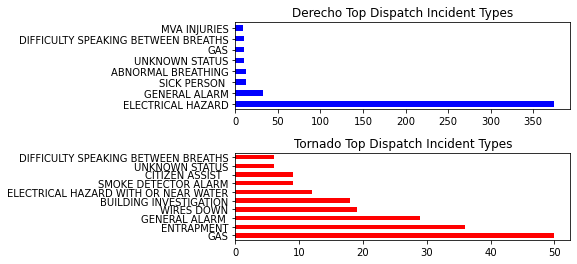

In [26]:
plt.subplot(2,1,1)
derechoTop10Incidents = derecho_dispatchdata['IncidentTypeDescription1'].value_counts().head(8)
derechoTop10Incidents.plot(kind='barh', title='Derecho Top Dispatch Incident Types', color='blue')
plt.subplot(2,1,2)
tornadoTop10Incidents = tornado_dispatchdata['IncidentTypeDescription1'].value_counts().head(10)
tornadoTop10Incidents.plot(kind='barh', title='Tornado Top Dispatch Incident Types', color='red')
#plt.xticks(wrap=True)
plt.subplots_adjust(hspace=.5)

In [28]:
top_tornado_incident_types = geo_tornado_dispatchdata.groupby('IncidentTypeDescription1').size().sort_values(ascending=False)
top_tornado_incident_types = top_tornado_incident_types.head(10).index.to_list()
topTornadogdf = geo_tornado_dispatchdata[geo_tornado_dispatchdata['IncidentTypeDescription1'].isin(top_tornado_incident_types)]
tornadoIncidentColors = ['aquamarine','deeppink','coral','darkgoldenrod','darkgreen','darkslateblue','maroon','mediumpurple','palegreen','dodgerblue']
tornadoColorDict = dict(zip(top_tornado_incident_types, tornadoIncidentColors))
map_tornado_incident_type = folium.Map(location = center, zoom_start = 12, tiles="CartoDB positron")
for ind, row in topTornadogdf.iterrows():
    folium.Circle(location = [row['Latitude1'],row['Longitude1']],radius=100,weight=4,color=tornadoColorDict[row['IncidentTypeDescription1']], fill=True).add_child(folium.Popup(row['IncidentTypeDescription1'])).add_to(map_tornado_incident_type)
map_tornado_incident_type = createLegend('../legendTornadoTypes.PNG',map_tornado_incident_type, 56, 6,100,250)
map_tornado_incident_type